## Collect and export the training data: **satellite image and the corresponding target classification map**

In [ ]:
## Mount on google drive
from google.colab import drive
drive.mount('/content/drive/')
# ## Authenticate to Google Cloud
from google.colab import auth
auth.authenticate_user()
# Authenticate to Earth Engine
import ee
ee.Authenticate()
ee.Initialize()


In [2]:
import os
os.chdir("/content/drive/My Drive/Earth-Engine-with-Deep-Learning")
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import folium
import time
from utils import imgShow
import matplotlib.pyplot as plt

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[NbConvertApp] Converting notebook utils.ipynb to python
[NbConvertApp] Writing 1883 bytes to utils.py


## Parameters configuration

In [23]:
### Super-parameters
# # output folder and name
# Project_ID = 'my-project-20200813'
# Bucket = 'earth-engine-bucket-1'
# Export_GStorage_Folder_tra = 'NLCD_Impervious_traData'   # !can't write into the second-level directory
# Export_GStorage_Folder_eva = 'NLCD_Impervious_evaData'   # !can't write into the second-level directory

Export_Drive_Folder = 'EE_Image'   # !can't write into the second-level directory
Export_TraData_Name = 'Train_Landsat8_2015_256_add'
Export_EvaData_Name = 'Eva_Landsat8_2015_256_add'

Label = 'impervious'
# Date of the collected Satellite data
date_start = '2015-01-01'
date_end = '2015-12-31'
# output bands
Bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']
# Bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']   # Specific the Landsat 5 and Landsat 7
Targets = [Label]
Kernel_shape = [256, 256]   # Specify the shape of patches expected by the model.

# Region (polygons) for training data collection
# TrainingPolys = ee.FeatureCollection(ee.Geometry.Rectangle(-78.9, 35.79, -80.00, 36.65))
TraPolys = ee.FeatureCollection('users/xin_luo/Impervious_Mapping_SZ/regionSelection/traRegion_E110N30')
EvaPolys = ee.FeatureCollection('users/xin_luo/Impervious_Mapping_SZ/regionSelection/evaRegion_E110N30')
tra_num_shards = 100    #  The numbers of shards in each polygon, this number is set to avoid the computed value too large error
tra_num_sam = 1000   #  Total sample size in each polygon.
eva_num_shards = 30    #  The numbers of shards in each polygon, this number is set to avoid the computed value too large error
eva_num_sam = 300   #  Total sample size in each polygon.


In [26]:
#### Data collection
## 1) satellite image source 
## for landsat 5
# image_collection = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR')\
#   .filterDate(date_start, date_end)\
#   .filter(ee.Filter.lt('CLOUD_COVER_LAND', 50))

image_collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')\
  .filterDate(date_start, date_end)\
  .filter(ee.Filter.lt('CLOUD_COVER_LAND', 100))

# image_collection = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR')\
#   .filterDate(date_start, date_end)\
#   .filter(ee.Filter.lt('CLOUD_COVER_LAND', 100))


# 1.1) cloud mask
def cloudMask(image):
    qa = image.select('pixel_qa')
    mask = qa.bitwiseAnd(1<<5).eq(0)
    return image.updateMask(mask)
image_mask = image_collection.map(cloudMask).median()

# 1.2) fill the null value of the cloud-masked image.
nullMask = image_mask.mask().Not()
img_nullMask = image_collection.map(lambda image_mask: image_mask.updateMask(nullMask)).median()
img_fill = image_mask.unmask(0).add(img_nullMask.unmask(0)).divide(10000)

# ## 2) NLCD dataset
# nlcd_imper = ee.Image('USGS/NLCD/NLCD2016').select('impervious')
# nlcd_imper = nlcd_imper.divide(100).float()
# # nlcd_imper = nlcd_imper.gt(.5)
## 2) MSMT_RF_Imper dataset
MSMT_RF_imper = ee.Image('users/xin_luo/Impervious_Mapping_SZ/MSMT_RF_Imper_E110N30')
MSMT_RF_imper = MSMT_RF_imper.add(-1).rename(Label)


In [27]:
####  Use folium to visualize the collected data and training regions.
# define the color of training regions
polyImage_tra = ee.Image(0).byte().paint(TraPolys, 1)
polyImage_tra = polyImage_tra.updateMask(polyImage_tra)
polyImage_eva = ee.Image(0).byte().paint(EvaPolys, 1)
polyImage_eva = polyImage_eva.updateMask(polyImage_eva)

mapid = img_fill.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
# mapid = img_fill.getMapId({'bands': ['B3', 'B2', 'B1'], 'min': 0, 'max': 0.3})
map = folium.Map(location=[26., 114], zoom_start=5)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
  ).add_to(map)
map

mapid = MSMT_RF_imper.getMapId({'min': 0, 'max': 1})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='impervious product',
  ).add_to(map)
# map.add_child(folium.LayerControl())
map

mapid = polyImage_tra.getMapId({'min': 1, 'max': 1, 'palette': ['red']})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='training polygons',
  ).add_to(map)
map

mapid = polyImage_eva.getMapId({'min': 1, 'max': 1, 'palette': ['yellow']})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='evaluation polygons',
  ).add_to(map)
map.add_child(folium.LayerControl())
map



### Stack the satellite image and the target classification map

In [28]:
## stack the satellite image and the target classification map
ImageStack = ee.Image.cat([
  img_fill.select(Bands),
  MSMT_RF_imper
]).float()
# define the kernel
list = ee.List.repeat(1, Kernel_shape[0])
lists = ee.List.repeat(list, Kernel_shape[1])
kernel = ee.Kernel.fixed(Kernel_shape[0], Kernel_shape[1], lists)  # patch size
neighborImage = ImageStack.neighborhoodToArray(kernel)    ### 变成了Neighborhood Image: 即Image中每个位置都是由一个二维Array构成
neighborImage

### **Sampling the stacked images to patches, and export the stacked images to tfrecord files.**
### <font color=red>! We could simplize the file export through specifing the formatOptions  (Awaiting for testing).</font> 
e.g., image_export_options = {'patchDimensions': [256, 256], 'maxFileSize': 304857600, 'compressed': True}

In [29]:
def samExport(PolysFeaColl, i_polys, num_shards, num_sam, neighImage=neighborImage):
    ''' 
    input:
        PolysFeaColl: ee.FeatureCollection()
        i_polys: the order of the polygons
        num_shards: the shards number of one polygon
        num_sam: the samples number of one polygon 
    output: 
    '''
    # Convert the feature collections to lists for iteration.
    PolysList = PolysFeaColl.toList(PolysFeaColl.size())
    geomSam = ee.FeatureCollection([])
    for i_shards in range(num_shards):
        sample = neighImage.sample(
        region = ee.Feature(PolysList.get(i_polys)).geometry(),
        scale = 30,
        numPixels = num_sam/num_shards, # Size of the shard. 采样的像元数（10个像元？）
        seed = i_polys,  # 采样的随机种子点
        tileScale = 8    ## ？？tileScale越大，输出的tile越小。tile:分布式计算时输入单元
        )
        geomSam = geomSam.merge(sample)
    return geomSam


In [30]:
### Export training data
for i_polygons in range(TraPolys.size().getInfo()):   ### 遍历每个polygon
    geomSam = samExport(PolysFeaColl=TraPolys, i_polys=i_polygons, 
                num_shards=tra_num_shards, num_sam=tra_num_sam, neighImage=neighborImage)    
    Image_Geom_Export_Name = Export_TraData_Name + '_Geom_' + str(i_polygons)   # 各个polygon对应的样本
    
    # ## export to Google Storage
    # task_GStorage = ee.batch.Export.table.toCloudStorage(
    #     collection = geomSam,
    #     description = Image_Geom_Export_Name,
    #     bucket = Bucket,
    #     fileNamePrefix = Export_GStorage_Folder_tra + '/' + Image_Geom_Export_Name,
    #     fileFormat = 'TFRecord',
    #     selectors = Bands + Targets
    # )
    # task_GStorage.start()
    
    ### export to Google Drive
    task_Drive = ee.batch.Export.table.toDrive(
        collection = geomSam,
        description = Image_Geom_Export_Name,
        folder = Export_Drive_Folder,
        fileNamePrefix = Image_Geom_Export_Name,
        fileFormat = 'TFRecord',
        selectors = Bands + Targets
    )
    task_Drive.start()


In [31]:
### Export evaluation data
for i_polygons in range(EvaPolys.size().getInfo()):   ### 遍历每个polygon
    geomSam = samExport(PolysFeaColl=EvaPolys, i_polys=i_polygons, 
                num_shards=eva_num_shards, num_sam=eva_num_sam, neighImage=neighborImage)    
    Image_Geom_Export_Name = Export_EvaData_Name + '_Geom_' + str(i_polygons)   # 各个polygon对应的样本
    # ## export to Google Storage
    # task_GStorage = ee.batch.Export.table.toCloudStorage(
    #     collection = geomSam,
    #     description = Image_Geom_Export_Name,
    #     bucket = Bucket,
    #     fileNamePrefix = Export_GStorage_Folder_eva + '/' + Image_Geom_Export_Name,
    #     fileFormat = 'TFRecord',
    #     selectors = Bands + Targets
    # )
    # task_GStorage.start()
    
    ### export to Google Drive
    task_Drive = ee.batch.Export.table.toDrive(
        collection = geomSam,
        description = Image_Geom_Export_Name,
        folder = Export_Drive_Folder,
        fileNamePrefix = Image_Geom_Export_Name,
        fileFormat = 'TFRecord',
        selectors = Bands + Targets
    )
    task_Drive.start()


In [ ]:
# while task_GStorage.active():
#   print('Polling for task (id: {}).'.format(task_GStorage.id))
#   time.sleep(30)

while task_Drive.active():
  print('Polling for task (id: {}).'.format(task_Drive.id))
  time.sleep(30)

print('Done with image export.')

In [ ]:
# visualize the prediction patch.
os.chdir('/content/drive/My Drive/EE_Image/MSMT_RF_Impervious_traData')

Bands_merge = Bands + Targets
imageColumns = [
    tf.io.FixedLenFeature(shape=Kernel_shape, dtype=tf.float32) 
      for k in Bands_merge
  ]
featuresDict = dict(zip(Bands_merge, imageColumns))    # 用于tfrecord文件中数据描述的字典

def parse_image(example_proto):
    return tf.io.parse_single_example(example_proto, featuresDict)

def toTensor(inputs):
    inputsList = [inputs.get(key) for key in Bands_merge]
    stacked = tf.stack(inputsList, axis=0)
    stacked = tf.transpose(stacked, [1, 2, 0])
    return stacked
tfrecord_file = Export_TraData_Name + '_Geom_0.tfrecord.gz'     # from Google Drive
# tfrecord_file = 'gs://earth-engine-bucket-1/' + Export_GStorage_Folder_eva + '/'\
#         + Export_EvaData_Name + '_Geom_0.tfrecord.gz'             # from Google Cloud Storage

imageDataset = tf.data.TFRecordDataset(tfrecord_file, compression_type='GZIP')
imageDataset = imageDataset.map(parse_image, num_parallel_calls=5)
imageDataset = imageDataset.map(toTensor).batch(1)
one_batch = iter(imageDataset)
one_batch.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


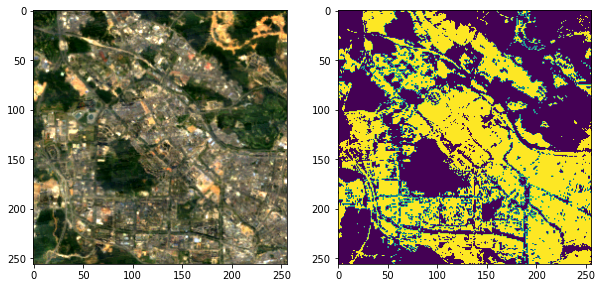

In [ ]:
# ### visiallize the patch
img = one_batch.next()
img = img[0].numpy()
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
imgShow(img, [2,1,0],1)
plt.subplot(1,2,2)
plt.imshow(img[:,:,6], vmin=0., vmax=1.)
